In [1]:
import os
import numpy as np
import pandas as pd
from PIL import ImageFont, ImageDraw, Image
import json
import cv2
import matplotlib.pyplot as plt

In [2]:
# 데이터 경로를 입력하세요

IMAGE_ROOT = "../../data/test/DCM"
LABEL_ROOT = "../../data/test/outputs_json"

In [3]:
import os
pngs = {
    os.path.relpath(os.path.join(root, fname), start=IMAGE_ROOT)
    for root, _dirs, files in os.walk(IMAGE_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".png"
}

In [4]:
jsons = {
    os.path.relpath(os.path.join(root, fname), start=LABEL_ROOT)
    for root, _dirs, files in os.walk(LABEL_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".json"
}

In [5]:
jsons_fn_prefix = {os.path.splitext(fname)[0] for fname in jsons}
pngs_fn_prefix = {os.path.splitext(fname)[0] for fname in pngs}

assert len(jsons_fn_prefix - pngs_fn_prefix) == 0
assert len(pngs_fn_prefix - jsons_fn_prefix) == 0

In [6]:
pngs = sorted(pngs)
jsons = sorted(jsons)

pngs = np.array(pngs)
jsons = np.array(jsons)

In [7]:
def load_image(image_path):
    return cv2.imread(image_path)

def load_json(label_path):
    with open(label_path,'r') as f:
        annotations = json.load(f)
    return annotations


In [8]:
CLASSES = [
    'finger-1', 'finger-2', 'finger-3', 'finger-4', 'finger-5',
    'finger-6', 'finger-7', 'finger-8', 'finger-9', 'finger-10',
    'finger-11', 'finger-12', 'finger-13', 'finger-14', 'finger-15',
    'finger-16', 'finger-17', 'finger-18', 'finger-19', 'Trapezium',
    'Trapezoid', 'Capitate', 'Hamate', 'Scaphoid', 'Lunate',
    'Triquetrum', 'Pisiform', 'Radius', 'Ulna', 'Bone'
]

CLASS2IND = {k:i for i,k in enumerate(CLASSES)}
IND2CLASS = {v:k for k, v in CLASS2IND.items()}

def annot_to_mask(image,annotations):
    annotation = annotations['annotations']
    metadata = annotations['metadata']
    img_size = image.shape[:-1]
    masks = np.zeros((len(CLASSES),img_size[0],img_size[1]))
    for i in annotation:
        layer = CLASS2IND[i['label']]
        points = np.array(i["points"])
        class_label = np.zeros((img_size[0],img_size[1]), dtype=np.uint8)
        cv2.fillPoly(class_label, [points],1)
        masks[layer] = class_label
    return masks

In [9]:
img_pth = '/data/ephemeral/home/data/train/DCM/ID012/image1661147072358.png'
img = load_image(img_pth)

j_p = '/data/ephemeral/home/data/train/outputs_json/ID012/image1661147072358.json'
jj = load_json(j_p)

In [10]:
import time
img = img/255.
annotations = jj["annotations"]
# (H, W, NC) 모양의 label을 생성합니다.
label_shape = tuple(img.shape[:2]) + (len(CLASSES), ) #(2048,2048,29)
label = np.zeros(label_shape, dtype=np.uint8)

# 클래스 별로 처리합니다.
for ann in annotations:
    c = ann["label"]
    class_ind = CLASS2IND[c]
    points = np.array(ann["points"])

    # polygon 포맷을 dense한 mask 포맷으로 바꿉니다.
    class_label = np.zeros(img.shape[:2], dtype=np.uint8) #(2048,2048)
    cv2.fillPoly(class_label, [points], 1)
    label[...,class_ind] = class_label
    #label[..., -1] += class_label
    #label = cv2.threshold(label, 1, 1, cv2.THRESH_BINARY)

inputs = {"image": img, "mask": (label>0).astype(np.uint8)}

In [11]:
inputs['mask'][:,:,19:].shape

(2048, 2048, 11)

In [12]:
output = np.transpose(inputs['mask'],(2,0,1))

In [12]:
PALETTE = [
    (220, 20, 60), (119, 11, 32), (0, 0, 142), (0, 0, 230), (106, 0, 228),
    (0, 60, 100), (0, 80, 100), (0, 0, 70), (0, 0, 192), (250, 170, 30),
    (100, 170, 30), (220, 220, 0), (175, 116, 175), (250, 0, 30), (165, 42, 42),
    (255, 77, 255), (0, 226, 252), (182, 182, 255), (0, 82, 0), (120, 166, 157),
    (110, 76, 0), (174, 57, 255), (199, 100, 0), (72, 0, 118), (255, 179, 240),
    (0, 125, 92), (209, 0, 151), (188, 208, 182), (0, 220, 176),
]

def label2rgb(label):
    image_size = label.shape[1:] + (3, )
    image = np.zeros(image_size, dtype=np.uint8)

    for i, class_label in enumerate(label):
        image[class_label == 1] = PALETTE[i]

    return image

def draw_image(image,json):
    label = annot_to_mask(image,json)
    fig, ax = plt.subplots(1, 2, figsize=(24, 12))
    ax[0].imshow(image) # remove channel dimension
    ax[0].axis('off')    
    ax[1].imshow(label2rgb(label))
    ax[1].axis('off')
    plt.show()

# RLE로 인코딩된 결과를 mask map으로 복원합니다.

def decode_rle_to_mask(rle, height, width):
    s = rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(height * width, dtype=np.uint8)
    
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    
    return img.reshape(height, width)

def predict_result(image_root, csv_root, i):
    image = cv2.imread(os.path.join(image_root,pngs[i]))
    png = pngs[i].split('/')[1]

    csvs = pd.read_csv(csv_root)
    rles = csvs.query("image_name == @png")['rle']
    
    preds = []
    for rle in rles:
        pred = decode_rle_to_mask(rle, height=2048, width=2048)
        preds.append(pred)

    preds = np.stack(preds, 0)
    fig, ax = plt.subplots(1, 2, figsize=(24, 12))
    ax[0].imshow(image)    # remove channel dimension
    ax[1].imshow(label2rgb(preds))

    plt.show()

In [ ]:
IMAGE_ROOT = "../../data/test/DCM"
CSV_ROOT = "/data/ephemeral/home/code/code/output/cw_ensemble_from_tu-xception71_tu-hrnet_w64_vgg19_mit-b3.csv"
predict_result(image_root=IMAGE_ROOT, csv_root=CSV_ROOT, i=70)

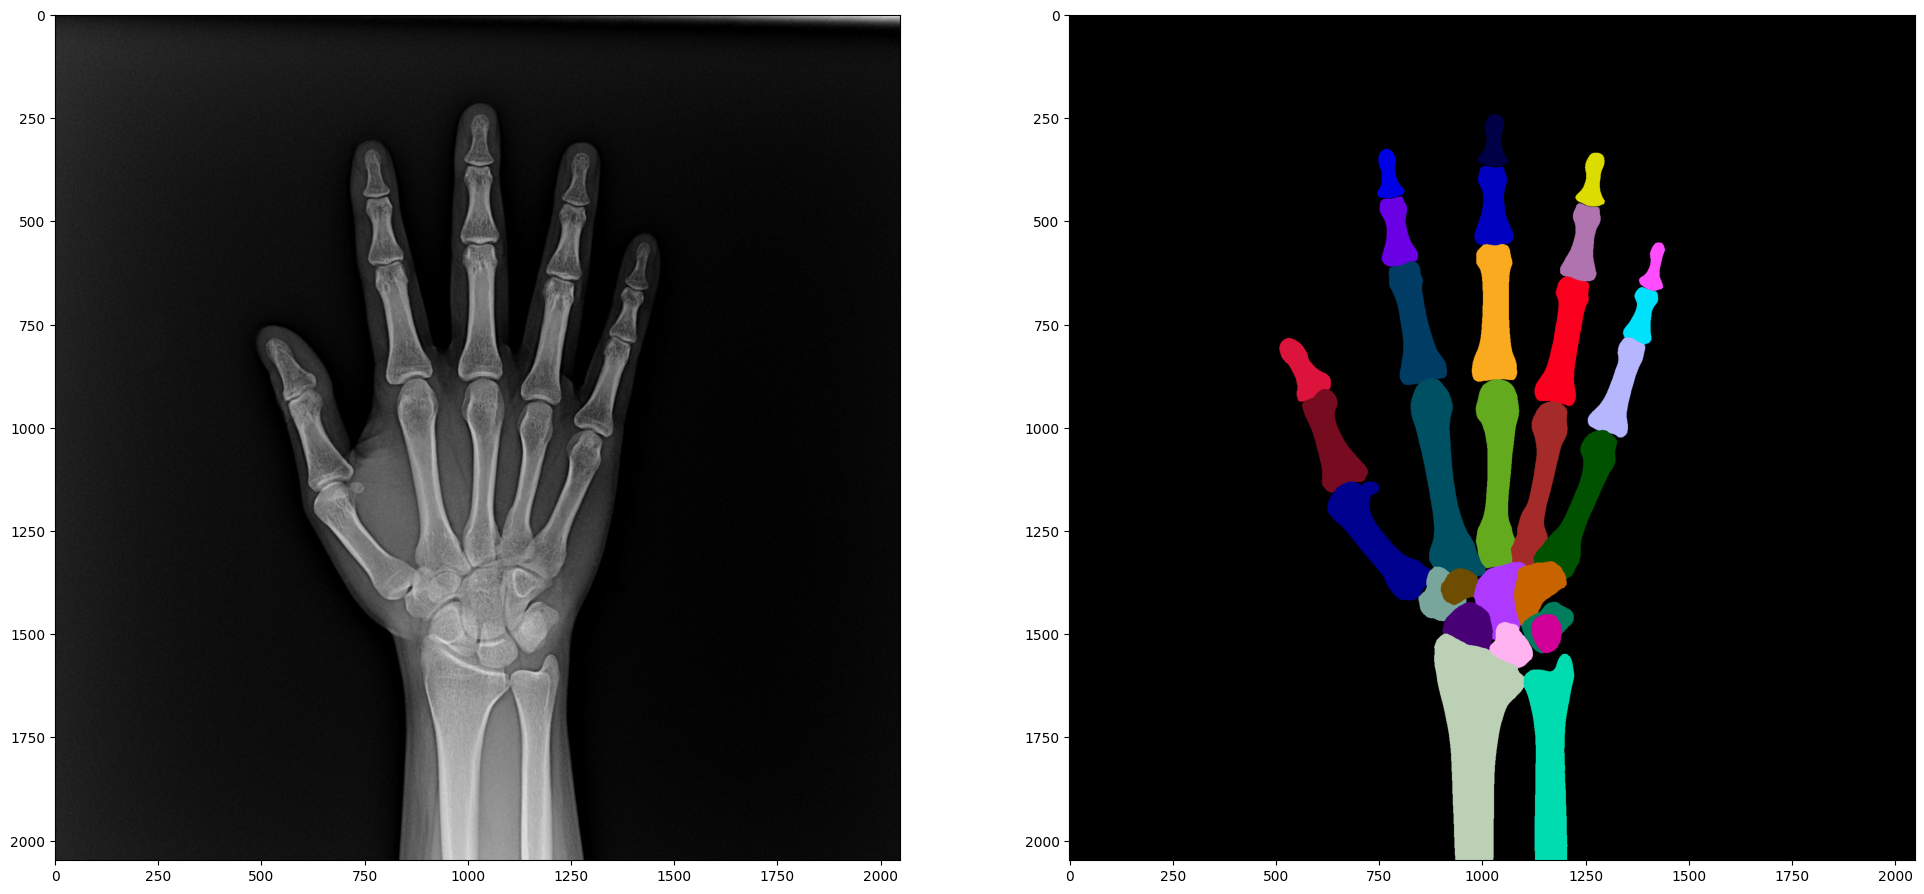

In [15]:
IMAGE_ROOT = "../../data/test/DCM"
CSV_ROOT = "/data/ephemeral/home/code/code/output/cw_ensemble_from_tu-xception71_tu-hrnet_w64_efficientnet-b2_vgg19_mit-b3.csv"
predict_result(image_root=IMAGE_ROOT, csv_root=CSV_ROOT, i=70)

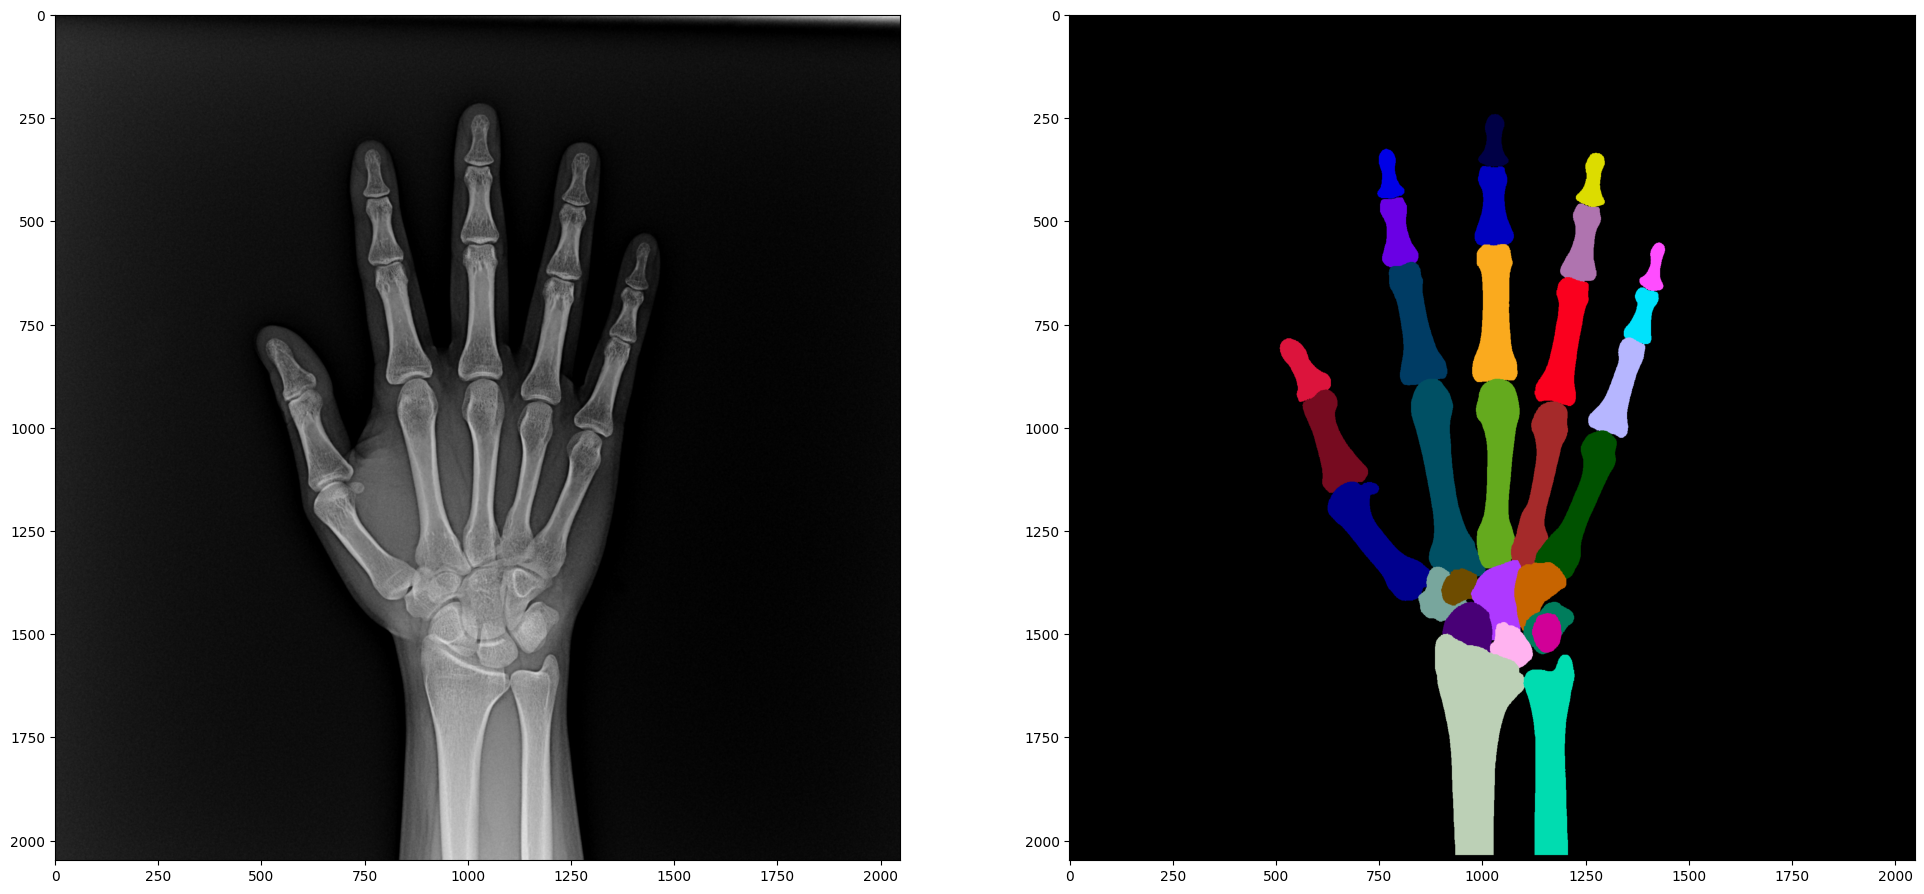

In [14]:
IMAGE_ROOT = "../../data/test/DCM"
CSV_ROOT = "/data/ephemeral/home/code/utils/dl3_xception71_ensemble_threshold_3.csv"
predict_result(image_root=IMAGE_ROOT, csv_root=CSV_ROOT, i=70)

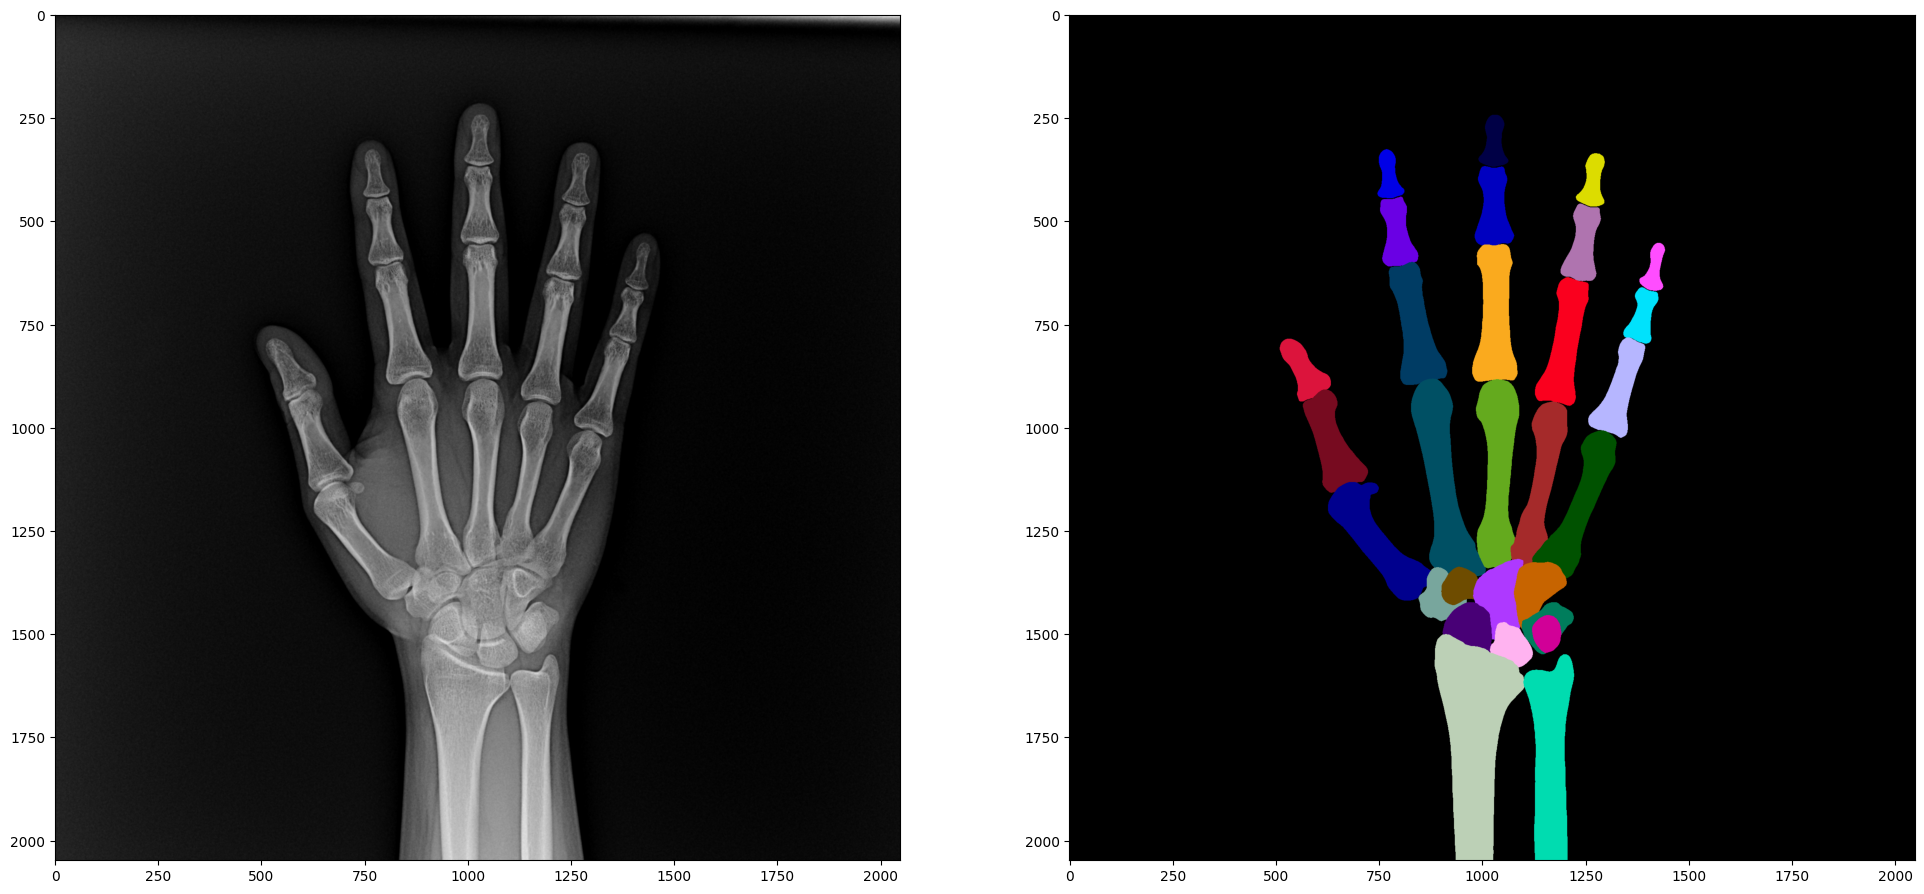

In [33]:
i = 70
image_root = "../../data/test/DCM"
csv_root = "../../code/code/output/Unet++HRnet64.csv"
image = cv2.imread(os.path.join(image_root,pngs[i]))
png = pngs[i].split('/')[1]

csvs = pd.read_csv(csv_root)
rles = csvs.query("image_name == @png")['rle']

preds = []
for rle in rles:
    pred = decode_rle_to_mask(rle, height=2048, width=2048)
    preds.append(pred)

preds = np.stack(preds, 0)
fig, ax = plt.subplots(1, 2, figsize=(24, 12))
ax[0].imshow(image)    # remove channel dimension
ax[1].imshow(label2rgb(preds))

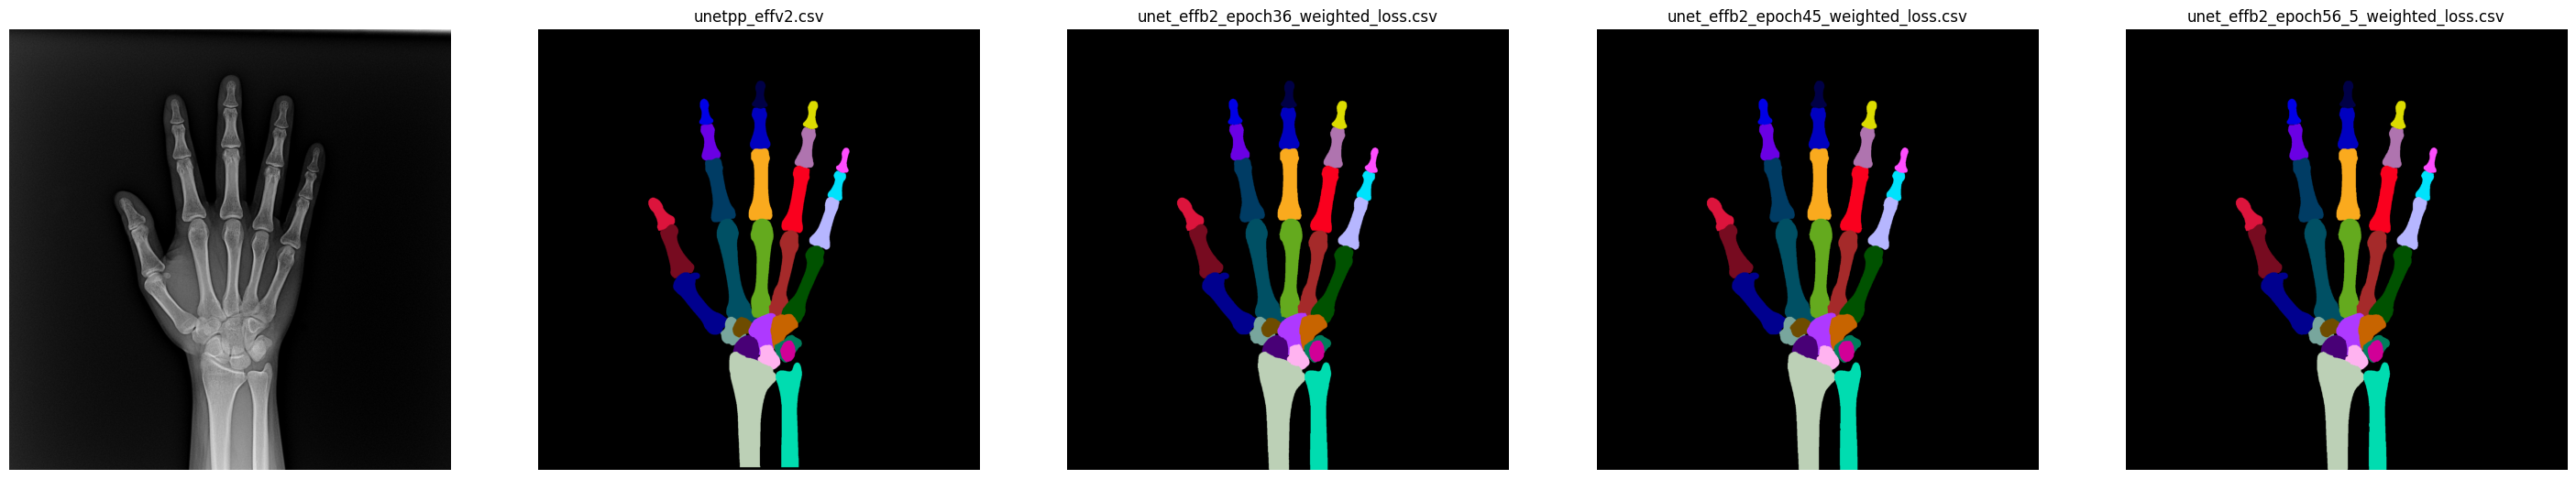

In [46]:
csv_names = ['unetpp_effv2.csv','unet_effb2_epoch36_weighted_loss.csv','unet_effb2_epoch45_weighted_loss.csv','unet_effb2_epoch56_5_weighted_loss.csv']
preds_image = []
for csv in csv_names:
    i = 70
    image_root = "../../data/test/DCM"
    csv_root = "../../code/code/output/" + csv
    image = cv2.imread(os.path.join(image_root,pngs[i]))
    png = pngs[i].split('/')[1]

    csvs = pd.read_csv(csv_root)
    rles2 = csvs.query("image_name == @png")['rle']
    preds2 = []
    for rle in rles2:
        pred2 = decode_rle_to_mask(rle, height=2048, width=2048)
        preds2.append(pred2)

    preds2 = np.stack(preds2, 0)
    preds_image.append(preds2)
fig, ax = plt.subplots(1, len(csv_names)+1, figsize=(36, 18))
for f in range(len(csv_names)+1):
    if f == 0:
        ax[f].imshow(image)    # remove channel dimension
        ax[f].axis('off')
    else:
        ax[f].imshow(label2rgb(preds_image[f-1]))
        ax[f].axis('off')
        ax[f].set_title(csv_names[f-1])
plt.show()

In [59]:
image_root = '/data/ephemeral/home/data/fold_4/train/DCM'
label_root = '/data/ephemeral/home/data/train/outputs_json'

pngs = sorted([
        os.path.relpath(os.path.join(root, fname), start=image_root)
        for root, _dirs, files in os.walk(image_root)
        for fname in files
        if os.path.splitext(fname)[1].lower() == ".png"
    ])
    
jsons = {i+'.json' for i in pngs_fn_prefix}

# 페어링 확인
pngs_fn_prefix = {os.path.splitext(fname)[0] for fname in pngs}
jsons_fn_prefix = {os.path.splitext(fname)[0] for fname in jsons}

assert len(jsons_fn_prefix - pngs_fn_prefix) == 0, "일부 JSON에 대응하는 PNG가 없습니다."
assert len(pngs_fn_prefix - jsons_fn_prefix) == 0, "일부 PNG에 대응하는 JSON이 없습니다."

In [57]:
len(pngs_fn_prefix)

640

Text(0.5, 1.0, 'mine')

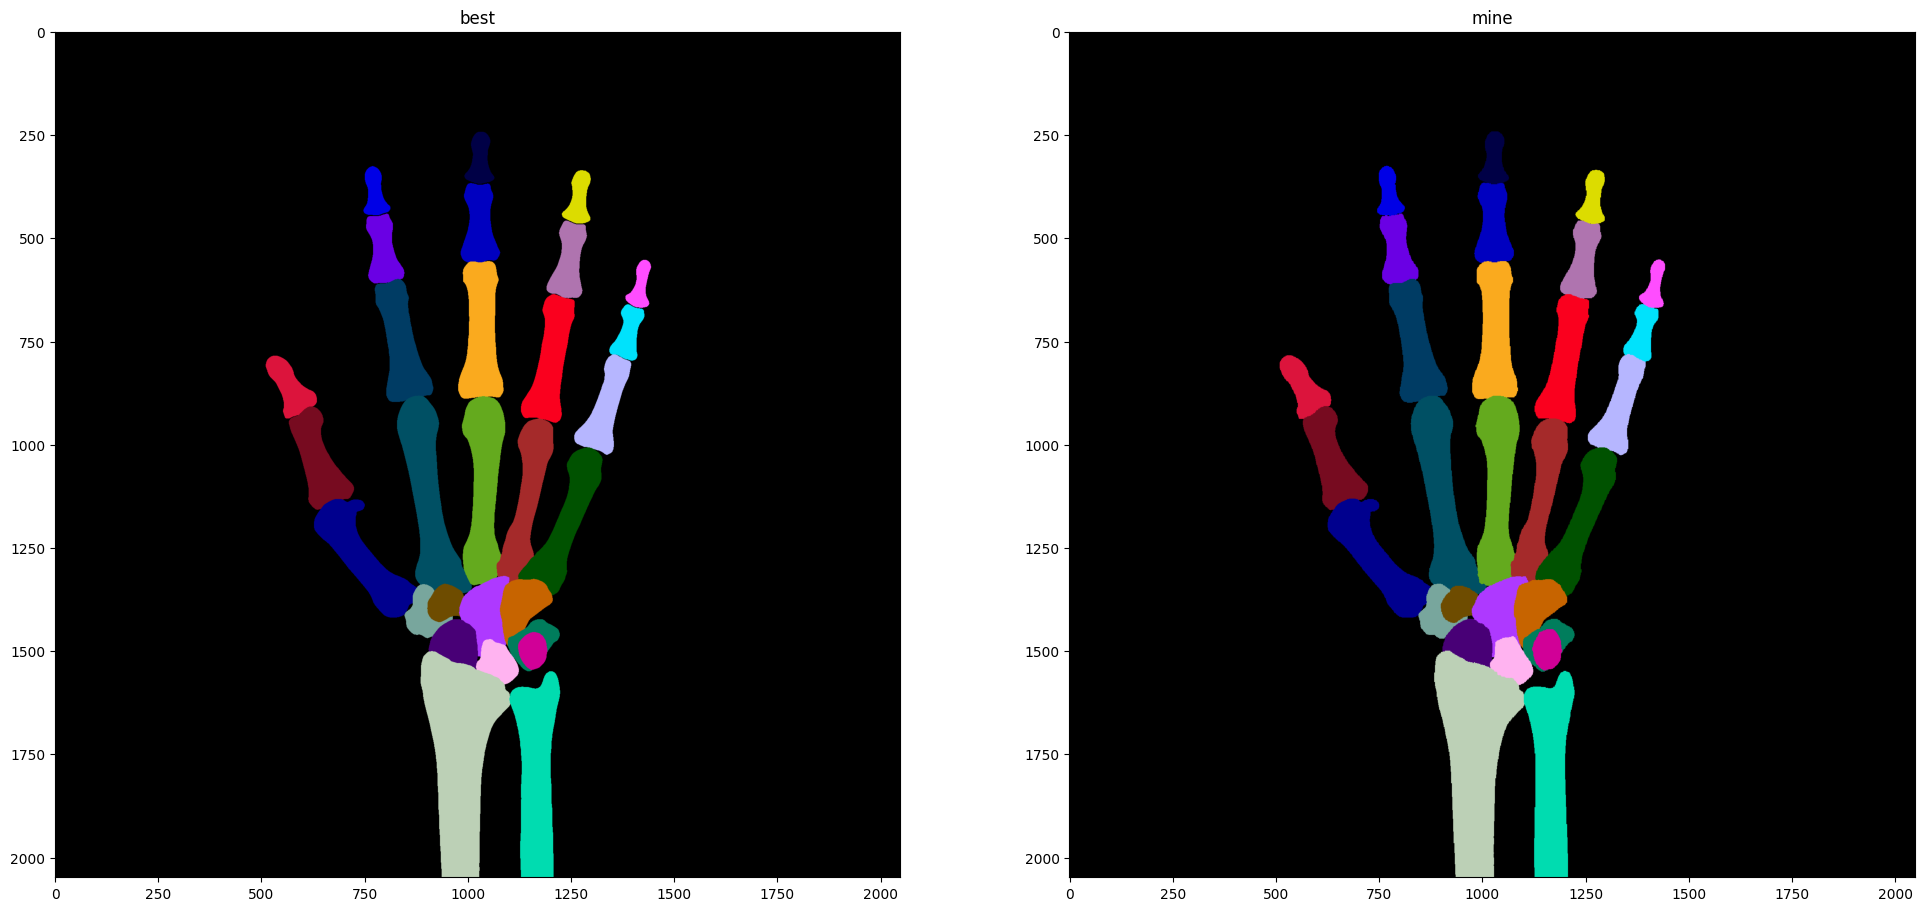

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))
ax[0].imshow(label2rgb(preds))    # remove channel dimension
ax[1].imshow(label2rgb(preds2))
ax[0].set_title('best')
ax[1].set_title('mine')

Text(0.5, 1.0, 'mine')

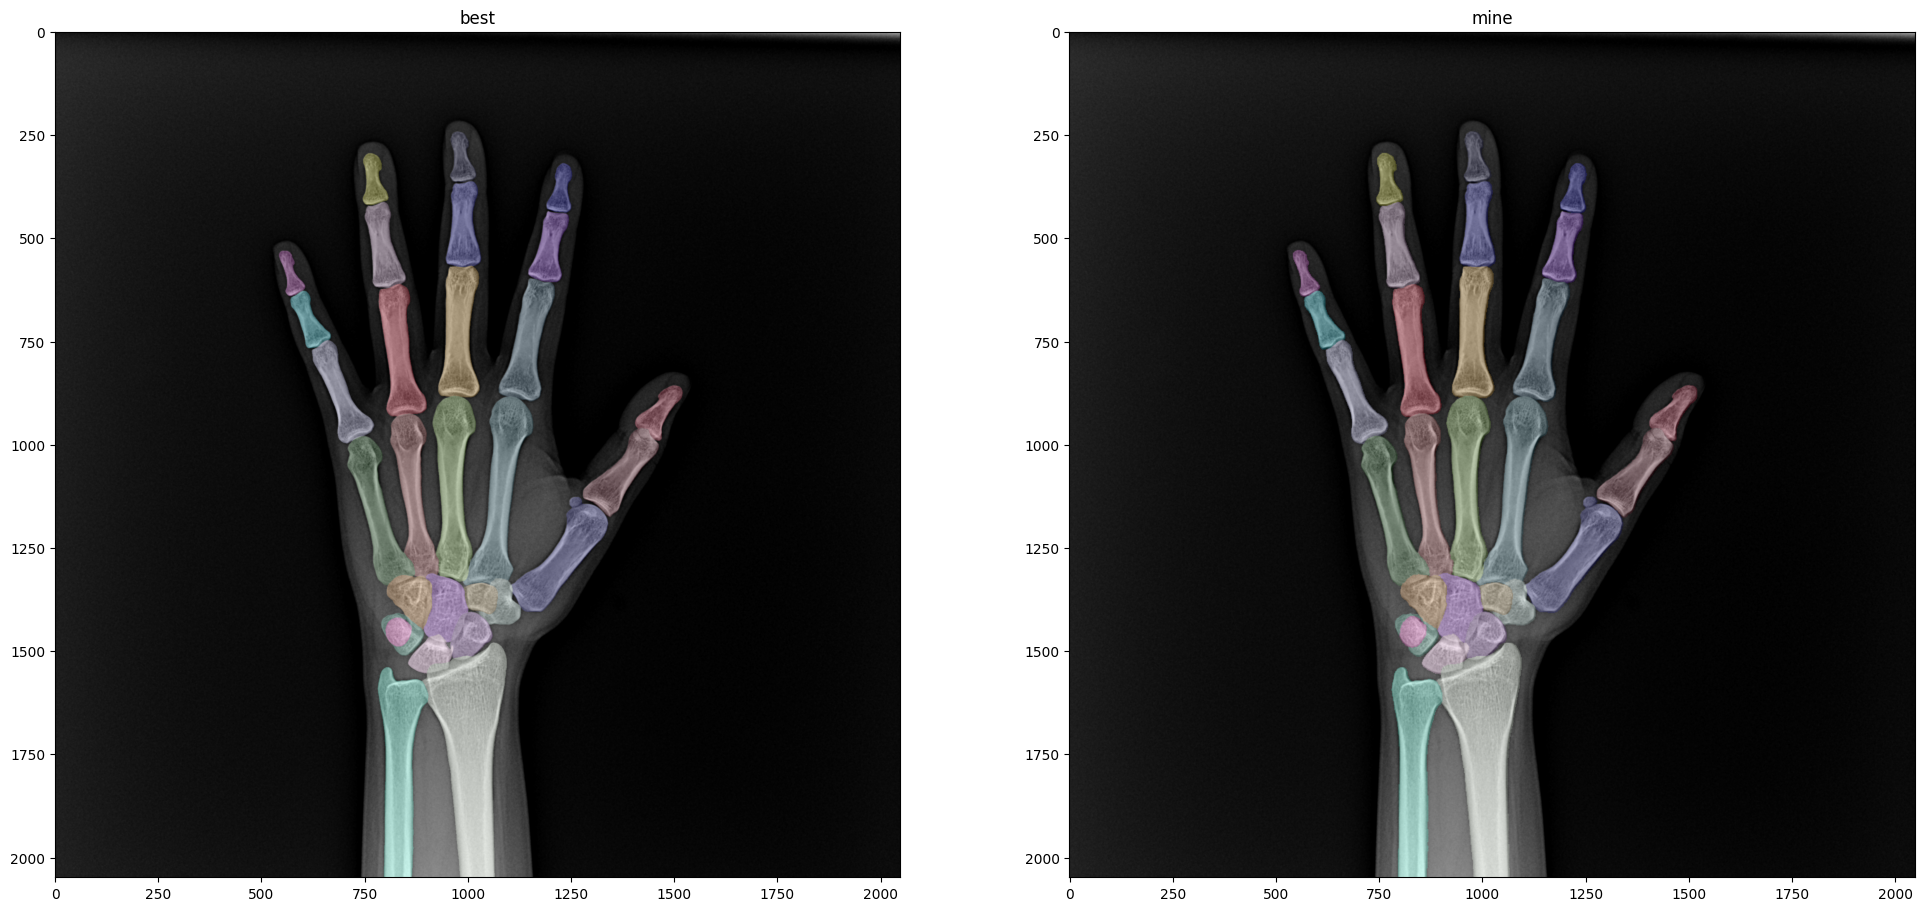

In [133]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))
ax[0].imshow((image*0.8+label2rgb(preds)*0.2).astype(np.uint8))    # remove channel dimension
ax[1].imshow((image*0.8+label2rgb(preds2)*0.2).astype(np.uint8))
ax[0].set_title('best')
ax[1].set_title('mine')

In [1]:
import zipfile
fold4 = zipfile.ZipFile('/data/ephemeral/home/data/fold_4.zip')
fold4.extractall('/data/ephemeral/home/data')